In [10]:
from __future__ import print_function

#Visualisation and Other packages
from time import time
import numpy as np
import matplotlib.pyplot as plt
#Scikit-learn packages
from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

In [11]:
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)

Automatically created module for IPython interactive environment


In [12]:
def dictionary_organism(species_name, train, test, coverages, xgrid, ygrid):
    #Dictionary for the organisms
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch

In [18]:
def plot_species_distribution(species=("bradypus_variegatus_0", "microryzomys_minutus_0")):
    #Plotting the species distribution
    t0 = time()
    # Load the compressed data
    data = fetch_species_distributions()
    # Initializing the x and y grid
    grid_x, grid_y = construct_grids(data)
    # Coordinates mapping
    coord_x, coord_y = np.meshgrid(grid_x, grid_y[::-1])

    # Species Bunch
    BV_bunch = dictionary_organism(species[0], data.train, data.test, data.coverages, grid_x, grid_y)
    MM_bunch = dictionary_organism(species[1], data.train, data.test, data.coverages, grid_x, grid_y)

    # Grid coordinates for feature engineering
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny, size=10000),
                              np.random.randint(low=0, high=data.Nx, size=10000)].T

    #Mapping to decide between land and water
    land_reference = data.coverages[6]

    # Prediction for each species
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Summary Statistics
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plotting map of continent SA
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=coord_y.min(), urcrnrlat=coord_y.max(), llcrnrlon=coord_x.min(), 
                        urcrnrlon=coord_x.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(coord_x, coord_y, land_reference, levels=[-9999], colors="k", linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Using training data to predict the distributions
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # Limiting our prediction to land coverages only
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)[:, 0]
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # Predicted contours
        plt.contourf(coord_x, coord_y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'], s=2 ** 2, c='black', 
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'], s=2 ** 2, c='black', marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # AUC Computation
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean)
                                          / std)[:, 0]
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)
        print("\n time elapsed: %.2fs" % (time() - t0))

________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868443

 time elapsed: 3.75s
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

 time elapsed: 6.59s


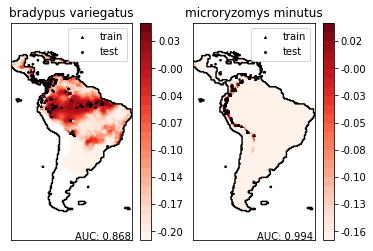

In [19]:
# Plotting the Species Distribution
plot_species_distribution()
plt.show()